## K-means Clustering
1. [读取并画出数据点](#读取并画出数据点)
3. [构建模型](#构建模型)
4. [指定聚类中心进行聚类](#指定聚类中心进行聚类)
4. [绘制聚类结果,以及聚类中心更新过程](#gx)
4. [Image compression with K-means](#img)
4. [四种在theano中计算point-by-point距离的方式](#四种在theano中计算point-by-point距离的方式)

In [1]:
import numpy as np
import theano
import theano.tensor as T
import time
import scipy.io as sio
from scipy import optimize
from scipy import misc
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

%matplotlib inline

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, CuDNN 3007)
/home/lsr/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### 读取并画出数据点

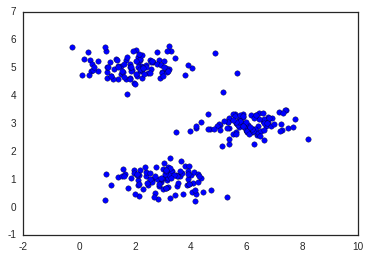

In [2]:
# load data
data = sio.loadmat('data/ex7data2.mat')
X = data['X']

# scatter
plt.scatter(X[:, 0], X[:, 1], s=30)

### 构建模型

In [3]:
x = T.matrix(name='x') # input data
initial_centroids = T.matrix(name='centroids') # initial_centroids
max_iter = T.iscalar(name='max_iter')
k = T.iscalar(name='k') # num of cluster

In [4]:
def run_Kmeans(centroids, x, k):
    x_DimShuffle = x.dimshuffle(0, 'x', 1)
    
    # 分配样本到每一个中心
    dist = T.sqrt(T.sum((x_DimShuffle - centroids.dimshuffle('x', 0, 1)) ** 2, axis=2)) # (n_sample, n_centroids)
    idx = T.argmin(dist, axis=1) # (n_sample, ) 聚类结果
  
    # 重新计算聚类中心
    def computeCentroids(i):
        return T.mean(x[T.nonzero(T.eq(idx, i))], axis=0)
    
    newCentroids, _ = theano.scan(computeCentroids, sequences=T.arange(k), outputs_info=None) # (n_centroids, n_dim)
    
    newDist = T.sqrt(T.sum((x_DimShuffle - newCentroids.dimshuffle('x', 0, 1)) ** 2, axis=2)) # (n_sample, n_centroids)
    
    # 重新分配样本到新的聚类中心
    newDist = T.sqrt(T.sum((x_DimShuffle - newCentroids.dimshuffle('x', 0, 1)) ** 2, axis=2)) # (n_sample, n_centroids)
    newIdx = T.argmin(newDist, axis=1) # (n_sample, ) 新的聚类结果
    
    numOfDiff = T.sum(T.neq(idx, newIdx)) # 聚类结果变化个数
    
    return [newCentroids, newIdx], theano.scan_module.until(T.eq(numOfDiff, 0)) # 终止条件为聚类结果不变

In [5]:
# 使用scan函数进行迭代优化
results, updates = theano.scan(run_Kmeans,
                                  outputs_info=[initial_centroids, None], 
                                  non_sequences=[x, k],
                                  n_steps=max_iter)

step_centroids, step_Idx = results[0], results[1]  # 返回每一次迭代时的聚类中心和聚类结果

K_Means = theano.function([x, initial_centroids, max_iter, k], [step_centroids, step_Idx[-1]]) # return the history of the centroids and final clustering idx

### 指定聚类中心进行聚类

In [6]:
initCentroids =  np.array([[3, 3], [6, 2], [8, 5]]).astype('float32') # init centroids
centroids_, idx_ = K_Means(X.astype('float32'), initCentroids, 10, 3) # clustering

In [7]:
centroids_ = np.concatenate([initCentroids.reshape(-1, 3, 2), centroids_], 0) # add initCentroids to centroids_

### 绘制聚类结果,以及聚类中心更新过程<span id='gx'/>

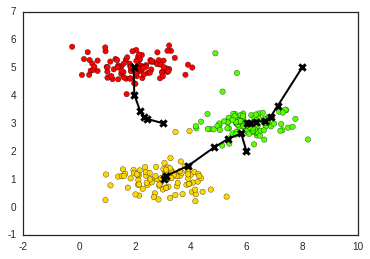

In [8]:
colors = np.array(['r', 'g', 'b'])
plt.scatter(X[:, 0], X[:, 1], c=idx_, cmap=plt.cm.prism, s=30) # plot samples with colors
plt.scatter(centroids_.reshape(-1, 2)[:, 0], centroids_.reshape(-1, 2)[:, 1], marker=u'x' ,c = 'black' ,  edgecolors='face', s=40, linewidths=3) # plot all candidate centroids

for i in range(centroids_.shape[1]): # Plot the history of the centroids with lines
    plt.plot(centroids_[:, i,:][:,0], centroids_[:, i,:][:,1], linewidth=2, color='black')

### Image compression with K-means<span id='img'/>

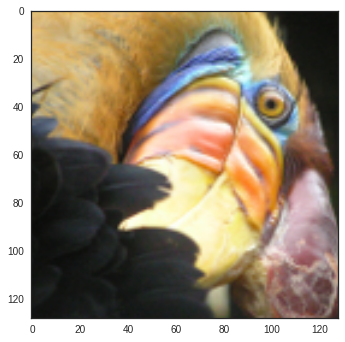

In [73]:
__img = misc.imread('data/bird_small.png')
img = __img.reshape(-1, 3) # reshape to (128 * 128, 3)
img = img.astype('float32') / 255 # Divide by 255 so that all values are in the range 0 - 1
plt.imshow(__img)

In [74]:
n_cluster = 16
n_maxIter = 10
initCentroids = img[np.random.permutation(img.shape[0])[:n_cluster]] # Initialize the centroids to be random examples

In [75]:
centroids_, idx_= K_Means(img, initCentroids, n_maxIter, n_cluster) # clustering

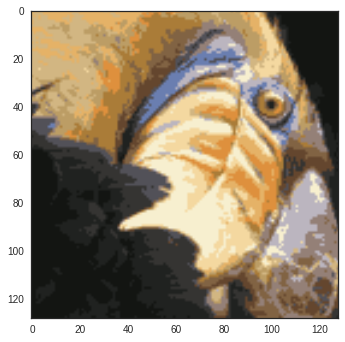

In [76]:
#  recover the image from the indices (idx) by mapping each pixel (specified by it's index in idx) to the centroid value
newImg = centroids_[-1][idx_]
newImg = newImg.reshape(__img.shape)
plt.imshow(newImg)

In [77]:
import cPickle as pkl
f = open('data/bird_Kmeans.pkl', 'wb')
pkl.dump([centroids_, idx_, img ], f, -1)
f.close()

## 四种在theano中计算point-by-point距离的方式

In [527]:
x = np.array([[1,2],[3,4],[6,7],[8,9]]).astype(theano.config.floatX) # (4, 2)
y = np.array([[1,2],[3,5]]).astype(theano.config.floatX) # (2, 2)

In [101]:
X_i = theano.shared(x[:, None, :], broadcastable=(False, True, False))
X_j = theano.shared(y[None, :, :], broadcastable=(True, False, False))

dX = (X_i - X_j)**2
Dsq = dX.sum(axis=2)
D = Dsq**0.5
f = theano.function([], D)
import time
start = time.time()
d = f()
print d.shape
print d
print time.time() - start

(4, 2)
[[ 0.          3.60555124]
 [ 2.82842731  1.        ]
 [ 7.07106829  3.60555124]
 [ 9.89949608  6.40312433]]
0.000900983810425


In [106]:
xx, yy = T.matrices(2)
result, updates = theano.scan(lambda x,z:T.sqrt(T.sum((x-z)**2,axis=1)), sequences=[xx], non_sequences=[yy])
ff = theano.function([xx, yy], result)
start = time.time()
print ff(x,y)
print time.time() - start

[[ 0.          3.60555124]
 [ 2.82842731  1.        ]
 [ 7.07106829  3.60555124]
 [ 9.89949608  6.40312433]]
0.00115704536438


In [114]:
dist2 = T.sqrt(T.sum((xx.dimshuffle(0, 'x', 1) - yy.dimshuffle('x', 0, 1)) ** 2, axis=2))
fff = theano.function([xx, yy], dist2)
start = time.time()
print fff(x,y)
print time.time() - start


[[ 0.          3.60555124]
 [ 2.82842731  1.        ]
 [ 7.07106829  3.60555124]
 [ 9.89949608  6.40312433]]
0.000913858413696


### compute p norm distance

In [123]:
P = T.scalar('P')
translation_vectors = xx.reshape((xx.shape[0], 1, -1)) - yy.reshape((1, yy.shape[0], -1))
minkowski_distances = (abs(translation_vectors) ** P).sum(2) ** (1. / P)
f_minkowski = theano.function([xx, yy, P], minkowski_distances)
start = time.time()
print f_minkowski(x, y, 2)
print time.time() - start


[[ 0.          3.60555124]
 [ 2.82842708  1.        ]
 [ 7.07106733  3.60555124]
 [ 9.89949512  6.40312481]]
0.000949859619141


### compute squared_euclidean_distances
only uses O(nX * nY) space instead of O(nX * nY * d) We check for correspondence, this time on the general problem: 

In [531]:
squared_euclidean_distances = (xx ** 2).sum(1).reshape((xx.shape[0], 1)) + (yy ** 2).sum(1).reshape((1, yy.shape[0])) - 2 * xx.dot(yy.T)
f_euclidean = theano.function([xx, yy], T.sqrt(squared_euclidean_distances))
start = time.time()
print f_euclidean(x, y)
print time.time() - start

[[ 0.          3.60555124]
 [ 2.82842731  1.        ]
 [ 7.07106829  3.60555124]
 [ 9.89949608  6.40312433]]
0.000911951065063
